# Initial Cleaning

In [97]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.signal import find_peaks

In [98]:
# Reading CSV files
demand_df = pd.read_csv("demand.csv", parse_dates=["Date"])
df_price = pd.read_csv("price.csv", parse_dates=["Date"])
df_weather = pd.read_csv("weather.csv", parse_dates=["Date"])

In [99]:
demand_df

,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,2016-07-03 21:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-03 21:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03 22:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-03 22:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-03 22:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148805,2020-09-30 22:45:00,96.9,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
148806,2020-09-30 23:00:00,96.9,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
148807,2020-09-30 23:15:00,37.4,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62
148808,2020-09-30 23:30:00,37.4,9.6,415.0,NaN,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94


In [100]:
# Hai's Smoothing Peaks Function
def smooth_like_butter(peaks, ar):
    '''
    Input in a list with all the indexes that have peaks and returns an array with all 
    the indexes being smoothed by taking the mean of the previous and the next value
    '''
    arr = copy.copy(ar)
    for peak in peaks:
        i = 1
        j = 1
        while arr[peak + i] == arr[peak]:
            i += 1
        while arr[peak - j] == arr[peak]:
            j += 1
        val = (arr[peak + i] + arr[peak - j]) / 2
        arr[peak - j:peak + i] = val
    return arr

# demand_df smoothing

# Find peaks and append to array
peaks, _ = find_peaks(demand_df['Building0'], height=700)
Building0_peaks = np.zeros(len(demand_df))
Building0_peaks[:] = np.NaN
for i in peaks:
    Building0_peaks[i] = demand_df['Building0'][i]

# save smoothed demand_df
demand_df['Building0'] = smooth_like_butter(peaks, demand_df['Building0'])
demand_df.to_csv("demand_smoothed_building0")

# Autoregressive Forecasting Setup 

In [101]:
# Auto Regressive Forecasting
# https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

# imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

demand_df = pd.read_csv("demand_smoothed_building0", parse_dates=["Date"])

In [102]:
# Remove empty rows
demand_df["Building0"].replace("", np.nan, inplace=True) # replaces empty string
demand_df.dropna(subset=["Building0"], inplace=True) # removes nan rows

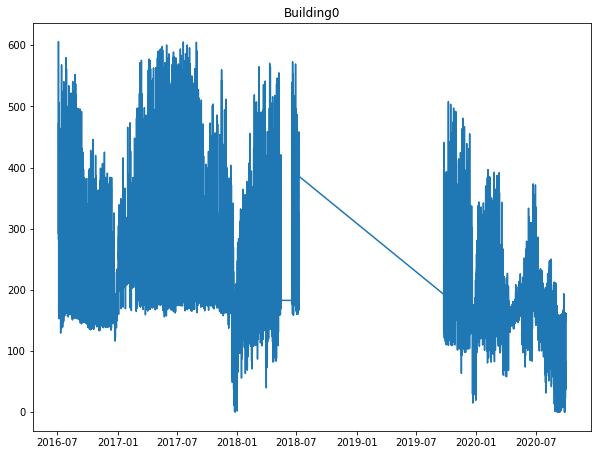

In [103]:
# Plot time series
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.show()

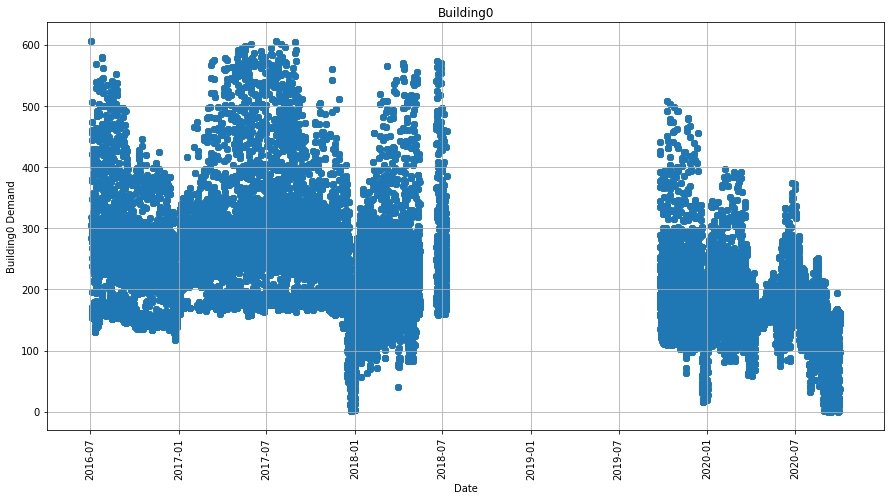

In [104]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(demand_df["Date"], demand_df["Building0"])
plt.title("Building0")
plt.ylabel("Building0 Demand")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [105]:
# AR(p) process requires stationary data, so let's take the log difference to make it stationary
demand_df["Building0"] = np.log(demand_df["Building0"])
demand_df["Building0"] = demand_df['Building0'].diff()
demand_df = demand_df.drop(demand_df.index[0])
demand_df

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
1,1,2016-07-03 21:45:00,0.000000,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-07-03 22:00:00,0.000000,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-07-03 22:15:00,0.758610,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-07-03 22:30:00,0.000000,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2016-07-03 22:45:00,0.000000,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148805,148805,2020-09-30 22:45:00,0.000000,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
148806,148806,2020-09-30 23:00:00,0.000000,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
148807,148807,2020-09-30 23:15:00,-0.952009,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62
148808,148808,2020-09-30 23:30:00,0.000000,9.6,415.0,NaN,NaN,38.6,38.10,9.55,9.03,8.02,6.08,31.94


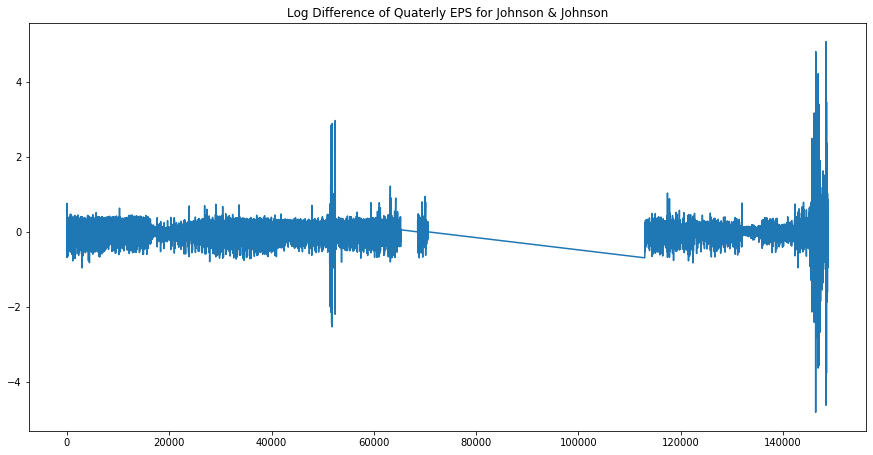

In [106]:
# Plot transformed time series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(demand_df["Building0"])
plt.title("Log Difference of Quaterly EPS for Johnson & Johnson")
plt.show()

Now the data appears to have no trend, but to ensure how stationary the data is we can use the Dick-Fuller test for statistical significance.

In [107]:
ad_fuller_result = adfuller(demand_df["Building0"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -67.7512399699171
p-value: 0.0


As we have a very large, negative ADF statistic and a low p-value - we can reject the null hypothesis and say that our time series is stationary.

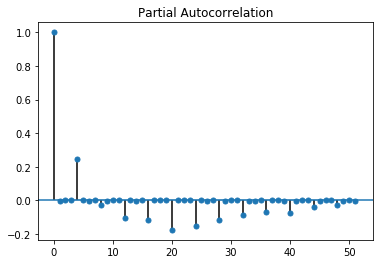

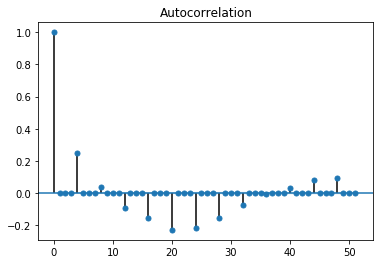

In [108]:
# Plot autocorrelation and partial autocorrelation plots
plot_pacf(demand_df["Building0"]);
plot_acf(demand_df["Building0"]);

Coefficients are least important after lag 4, now use a Yule-Walker equation to estimate of AR(p) of order 4

# Autoregressive Model of Order 4

In [109]:
# Try a AR(4) model
rho, sigma = yule_walker(demand_df["Building0"], 4)
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [ 1.08891458e-03  6.63899293e-05 -1.51123107e-04 -2.47844363e-01]
sigma: 0.09567382676382685


Therefore, the function is best approximated for:

y_t = 0.09 + 1.089*10^-3*y_t-1 + 6.639*10^-5*y_t-2 - 1.511*10^-4*y_t-3 - 2.478*10^-1*y_t-4